In [1]:
import json, random, os
import matplotlib.pyplot as plt
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain_core.documents import Document
from langchain_community.vectorstores import FAISS
from tqdm.notebook import tqdm
from langchain_community.retrievers import BM25Retriever
from sentence_transformers import SentenceTransformer, util
from PIL import Image

DATA_DIR = "/mnt/data/factcheck/averimatec"
SPLIT = "test"

model = SentenceTransformer("clip-ViT-B-32", device="cuda")

# embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL, model_kwargs={"device": "cuda:0"})
random.seed(111)

with open(f"{DATA_DIR}/{SPLIT}.json") as f:
    datapoints = json.load(f)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
len(datapoints)

352

In [3]:
datapoints[2]

{'date': '2023-10-12',
 'location': 'IL',
 'claim_text': "Photo shows a deceased newborn being recovered from rubble in the aftermath of Israel's recent airstrikes on the city of Gaza.",
 'claim_images': ['6787bb68e2f02e5f498179d1#CLAIM#0.jpg'],
 'metadata': {'speaker': '@sWilinsonbc',
  'transcription': '',
  'media_source': '',
  'original_claim_url': '',
  'reporting_source': 'X (formally Twitter)',
  'modality': 'Image-text',
  'image_used': 'Yes'},
 'questions': [],
 'justification': '',
 'article': '',
 'label': ''}

In [4]:
import os
from glob import glob


def generate_clip_embeddings(images_path, model):

    image_paths = glob(os.path.join(images_path, "**/*.jpg"), recursive=True)

    embeddings = []
    for img_path in image_paths:
        try:
            image = Image.open(img_path)
            embedding = model.encode(image)
            embeddings.append(embedding)
        except Exception as e:
            print(f"Error encoding image {img_path}: {e}")

    return embeddings, image_paths

In [5]:
import faiss
import numpy as np


def create_faiss_index(embeddings, image_paths, output_path):

    dimension = len(embeddings[0])
    index = faiss.IndexFlatIP(dimension)
    index = faiss.IndexIDMap(index)

    vectors = np.array(embeddings).astype(np.float32)

    # Add vectors to the index with IDs
    index.add_with_ids(vectors, np.array(range(len(embeddings))))

    # Save the index
    faiss.write_index(index, output_path)
    print(f"Index created and saved to {output_path}")

    # Save image paths
    with open(output_path + ".paths", "w") as f:
        for img_path in image_paths:
            f.write(img_path + "\n")

    return index


In [6]:
SPLIT

'test'

In [7]:
for CLAIM_ID in tqdm(range(151,len(datapoints))):
    # skip if f"{DATA_DIR}/data_store/vecstore/{SPLIT}/4k/{CLAIM_ID}" exists
    if os.path.exists(f"{DATA_DIR}/vector_store/{SPLIT}/image/{CLAIM_ID}"):
        continue

    os.makedirs(f"{DATA_DIR}/vector_store/{SPLIT}/image/{CLAIM_ID}")
    datapoint = datapoints[CLAIM_ID]
    claim = datapoint["claim_text"]
    # display(Markdown("### 🗯️ " + claim + " [" + datapoint["label"] + "]"))
    embeddings, image_paths = generate_clip_embeddings(
        f"{DATA_DIR}/knowledge_store/{SPLIT}/image_related/image_related_store_image_{SPLIT}/{CLAIM_ID}",model
    )
    index = create_faiss_index(embeddings, image_paths, f"{DATA_DIR}/vector_store/{SPLIT}/image/{CLAIM_ID}/faiss.index")
    #db = FAISS.from_documents(chunks_pruned, embeddings)
#    db.save_local(f"{DATA_DIR}/vector_store/{SPLIT}/image/{CLAIM_ID}")

  0%|          | 0/201 [00:00<?, ?it/s]

In [8]:
def retrieve_similar_images(query, model, index, image_paths, top_k=3):

    # query preprocess:
    if query.endswith(
        (".png", ".jpg", ".jpeg", ".tiff", ".bmp", ".gif", ".webp")
    ):  # Check if the query is an image file
        query = Image.open(query)

    query_features = model.encode(query)
    query_features = query_features.astype(np.float32).reshape(1, -1)

    distances, indices = index.search(query_features, top_k)

    retrieved_images = [image_paths[int(idx)] for idx in indices[0]]

    return query, retrieved_images

In [9]:
import matplotlib.pyplot as plt


def visualize_results(query, retrieved_images):
    plt.figure(figsize=(12, 5))

    # If image query
    if isinstance(query, Image.Image):
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.imshow(query)
        plt.title("Query Image")
        plt.axis("off")
        start_idx = 2

    # If text query
    else:
        plt.subplot(1, len(retrieved_images) + 1, 1)
        plt.text(0.5, 0.5, f"Query:\n\n '{query}'", fontsize=16, ha="center", va="center")
        plt.axis("off")
        start_idx = 2

    # Display images
    for i, img_path in enumerate(retrieved_images):

        plt.subplot(1, len(retrieved_images) + 1, i + start_idx)
        plt.imshow(Image.open(img_path))
        plt.title(f"Match {i + 1}")
        plt.axis("off")

    plt.show()

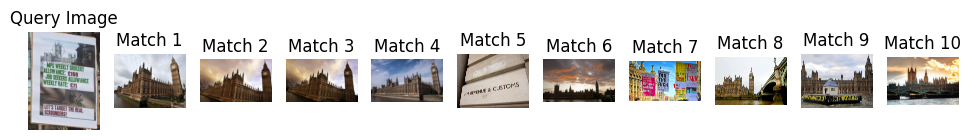

In [10]:
CLAIM_ID = 25
datapoint = datapoints[CLAIM_ID]
claim_image_filename = datapoint['claim_images'][0]
query_image_path = os.path.join(DATA_DIR, "images", claim_image_filename)

index_path = f"{DATA_DIR}/vector_store/{SPLIT}/image/{CLAIM_ID}/faiss.index"
index = faiss.read_index(index_path)

with open(index_path + ".paths", "r") as f:
    image_paths = [line.strip() for line in f]

query, retrieved_images = retrieve_similar_images(query_image_path, model, index, image_paths, top_k=10)
visualize_results(query, retrieved_images)

In [12]:
retrieve_similar_images(claim, model, index, image_paths, top_k=3)

('Rahul Gandhi was photographed with an ISI agent.',
 ['/mnt/data/factcheck/averimatec/knowledge_store/test/image_related/image_related_store_image_test/18/362.jpg',
  '/mnt/data/factcheck/averimatec/knowledge_store/test/image_related/image_related_store_image_test/18/337.jpg',
  '/mnt/data/factcheck/averimatec/knowledge_store/test/image_related/image_related_store_image_test/18/57.jpg'])

In [17]:
def fetch_image_document(image_path, split=SPLIT):
    # derives a line from a file like /mnt/data/factcheck/averimatec/knowledge_store/test/text_related/image_related_store_text_test/5.json based on the image_path
    parts = image_path.split("/")
    claim_id, image_id = parts[-2], int(parts[-1].split(".")[0])
    json_path = (
        f"{DATA_DIR}/knowledge_store/{split}/text_related/image_related_store_text_{split}/{claim_id}.json"
    )
    # load  json lines
    i = 0
    with open(json_path) as f:
        for line in f:
            i += 1
            if i != image_id:
                continue
            return json.loads(line)
            

In [21]:
retrieved_images[0]

'/mnt/data/factcheck/averimatec/knowledge_store/test/image_related/image_related_store_image_test/18/362.jpg'

In [19]:
res =fetch_image_document(retrieved_images[0], split=SPLIT)
res

In [20]:
print(res)

None


### 🗯️ A viral image shows Sahar Ata Bandial, the daughter of Pakistan’s former top judge, Umar Ata Bandial. []


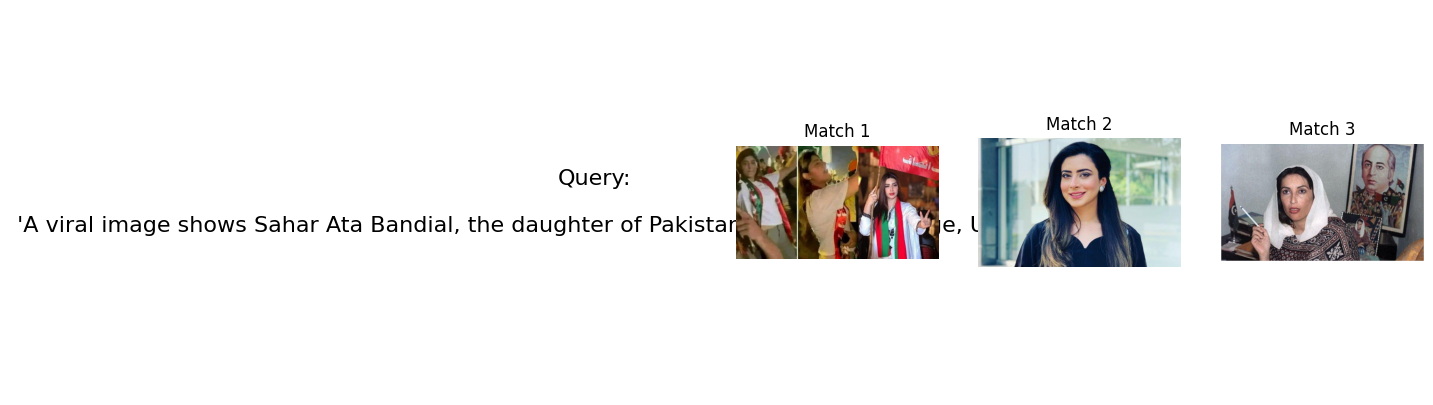

### 🗯️ Image shows Ukrainian military uniform that has been designed for pregnant women. []


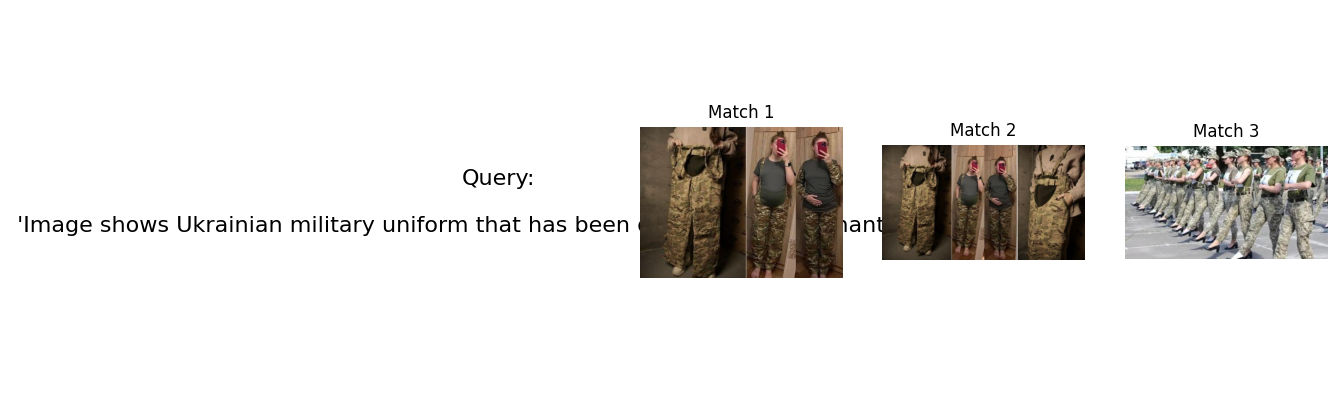

### 🗯️ A photo of Katalin Karikó and Drew Weissman the 2023 Nobel Prize laureates in physiology that shows them wearing face masks demonstrate that they do not trust their own innovation in the field of mRNA vaccine development []


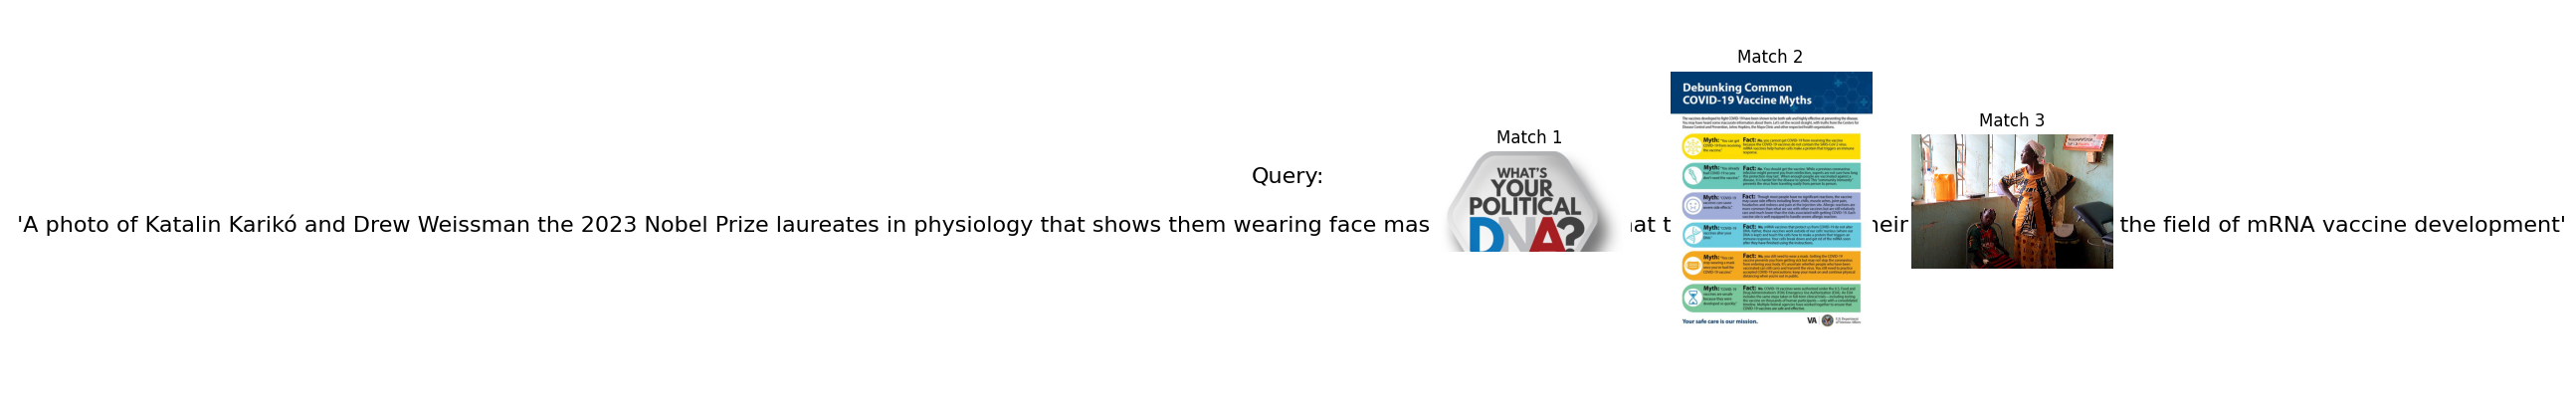

### 🗯️ Rahul Gandhi was photographed with an ISI agent. []


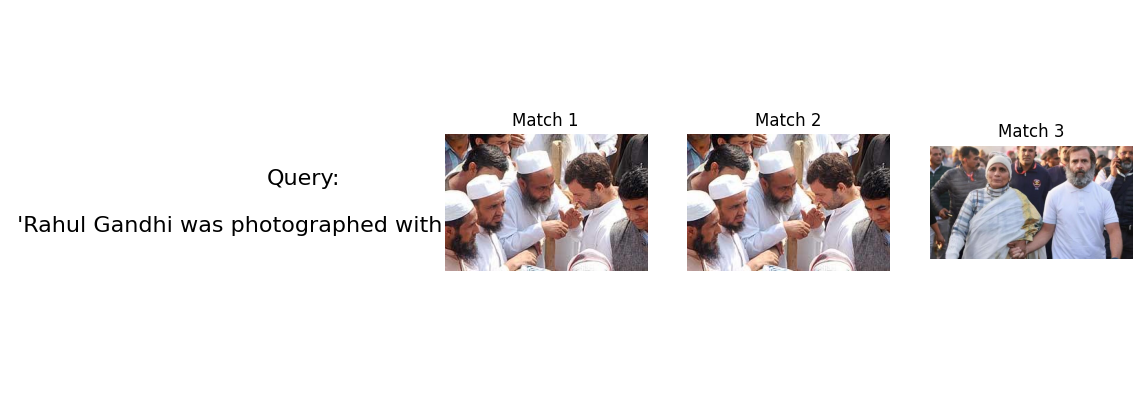

In [ ]:
# scroll thru previous CLAIM_IDs
for CLAIM_ID in range(15,19):
    datapoint = datapoints[CLAIM_ID]
    claim = datapoint["claim_text"]
    print(f"### 🗯️ {claim} [{datapoint['label']}]")
    index_path = f"{DATA_DIR}/vector_store/{SPLIT}/image/{CLAIM_ID}/faiss.index"
    index = faiss.read_index(index_path)

    with open(index_path + ".paths", "r") as f:
        image_paths = [line.strip() for line in f]

    query, retrieved_images = retrieve_similar_images(claim, model, index, image_paths, top_k=3)
    visualize_results(query, retrieved_images)